# Association Rule Mining - FP-Growth

Notebook này thực hiện Association Rule Mining sử dụng thuật toán FP-Growth để tìm các mẫu kết hợp giữa các chỉ số cầu thủ và đội bóng.

## Mục tiêu:
1. Discretize các biến liên tục
2. Áp dụng FP-Growth để tìm frequent itemsets
3. Generate association rules
4. Đánh giá và visualize rules


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')
from association_rules import (
    discretize_continuous_features, create_transaction_dataset,
    apply_fpgrowth, generate_rules, analyze_player_performance_patterns,
    analyze_team_patterns
)

# Cấu hình
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Đã import các modules cần thiết")


✅ Đã import các modules cần thiết


## 1. Load dữ liệu đã xử lý


In [2]:
# Load dữ liệu
try:
    players_df = pd.read_excel('../data/players_processed.xlsx')
    print(f"✅ Đã load dữ liệu cầu thủ: {players_df.shape}")
except:
    # Nếu chưa có file processed, load từ file gốc
    from data_preprocessing import load_data, feature_engineering_players, prepare_data_for_analysis
    data = load_data()
    players_df = feature_engineering_players(data['players'])
    players_df = prepare_data_for_analysis(players_df)
    print(f"✅ Đã load và xử lý dữ liệu cầu thủ: {players_df.shape}")

try:
    teams_df = pd.read_excel('../data/teams_processed.xlsx')
    print(f"✅ Đã load dữ liệu đội bóng: {teams_df.shape}")
except:
    from data_preprocessing import load_data, feature_engineering_teams, prepare_data_for_analysis
    data = load_data()
    teams_merged = feature_engineering_teams(data['teams_for'], data['teams_vs'])
    if teams_merged is not None:
        teams_df = prepare_data_for_analysis(teams_merged, target_cols=['Squad'])
        print(f"✅ Đã load và xử lý dữ liệu đội bóng: {teams_df.shape}")
    else:
        teams_df = None
        print("⚠️ Không có dữ liệu đội bóng")


✅ Đã load dữ liệu cầu thủ: (574, 146)
✅ Đã load dữ liệu đội bóng: (20, 44)


## 2. Phân tích mẫu chỉ số cầu thủ


In [3]:
# Phân tích mẫu chỉ số cầu thủ
print("="*70)
print("PHÂN TÍCH MẪU CHỈ SỐ CẦU THỦ")
print("="*70)

frequent_itemsets_players, rules_players, players_discrete = analyze_player_performance_patterns(
    players_df, min_support=0.15, min_confidence=0.6
)

if frequent_itemsets_players is not None and len(frequent_itemsets_players) > 0:
    print(f"\n✅ Tìm thấy {len(frequent_itemsets_players)} frequent itemsets")
    print(f"✅ Tạo được {len(rules_players)} association rules")
    
    # Hiển thị top frequent itemsets
    print("\n" + "="*70)
    print("TOP 10 FREQUENT ITEMSETS:")
    print("="*70)
    print(frequent_itemsets_players.head(10).to_string())
    
    # Hiển thị top rules
    if len(rules_players) > 0:
        print("\n" + "="*70)
        print("TOP 20 ASSOCIATION RULES (sorted by confidence and lift):")
        print("="*70)
        print(rules_players.head(20)[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())
else:
    print("⚠️ Không tìm thấy patterns. Hãy thử giảm min_support hoặc min_confidence")


PHÂN TÍCH MẪU CHỈ SỐ CẦU THỦ
📊 Đang phân tích với 6 features: ['shooting_Standard_Gls', 'passing_Ast', 'shooting_Expected_xG', 'passing_xAG', 'shooting_Standard_SoT%']...

✅ Tìm thấy 70 frequent itemsets
✅ Tạo được 207 association rules

TOP 10 FREQUENT ITEMSETS:
    support                                  itemsets
0  0.526132      (shooting_Standard_Gls_category=Low)
1  0.524390                (passing_Ast_category=Low)
2  0.364111                                  (Pos=DF)
3  0.343206       (shooting_Expected_xG_category=Low)
4  0.334495     (shooting_Standard_SoT%_category=Low)
5  0.311847             (passing_xAG_category=Medium)
6  0.374564                (passing_xAG_category=Low)
7  0.334495  (shooting_Standard_SoT%_category=Medium)
8  0.329268    (shooting_Expected_xG_category=Medium)
9  0.315331     (shooting_Standard_Gls_category=High)

TOP 20 ASSOCIATION RULES (sorted by confidence and lift):
                                                                                   

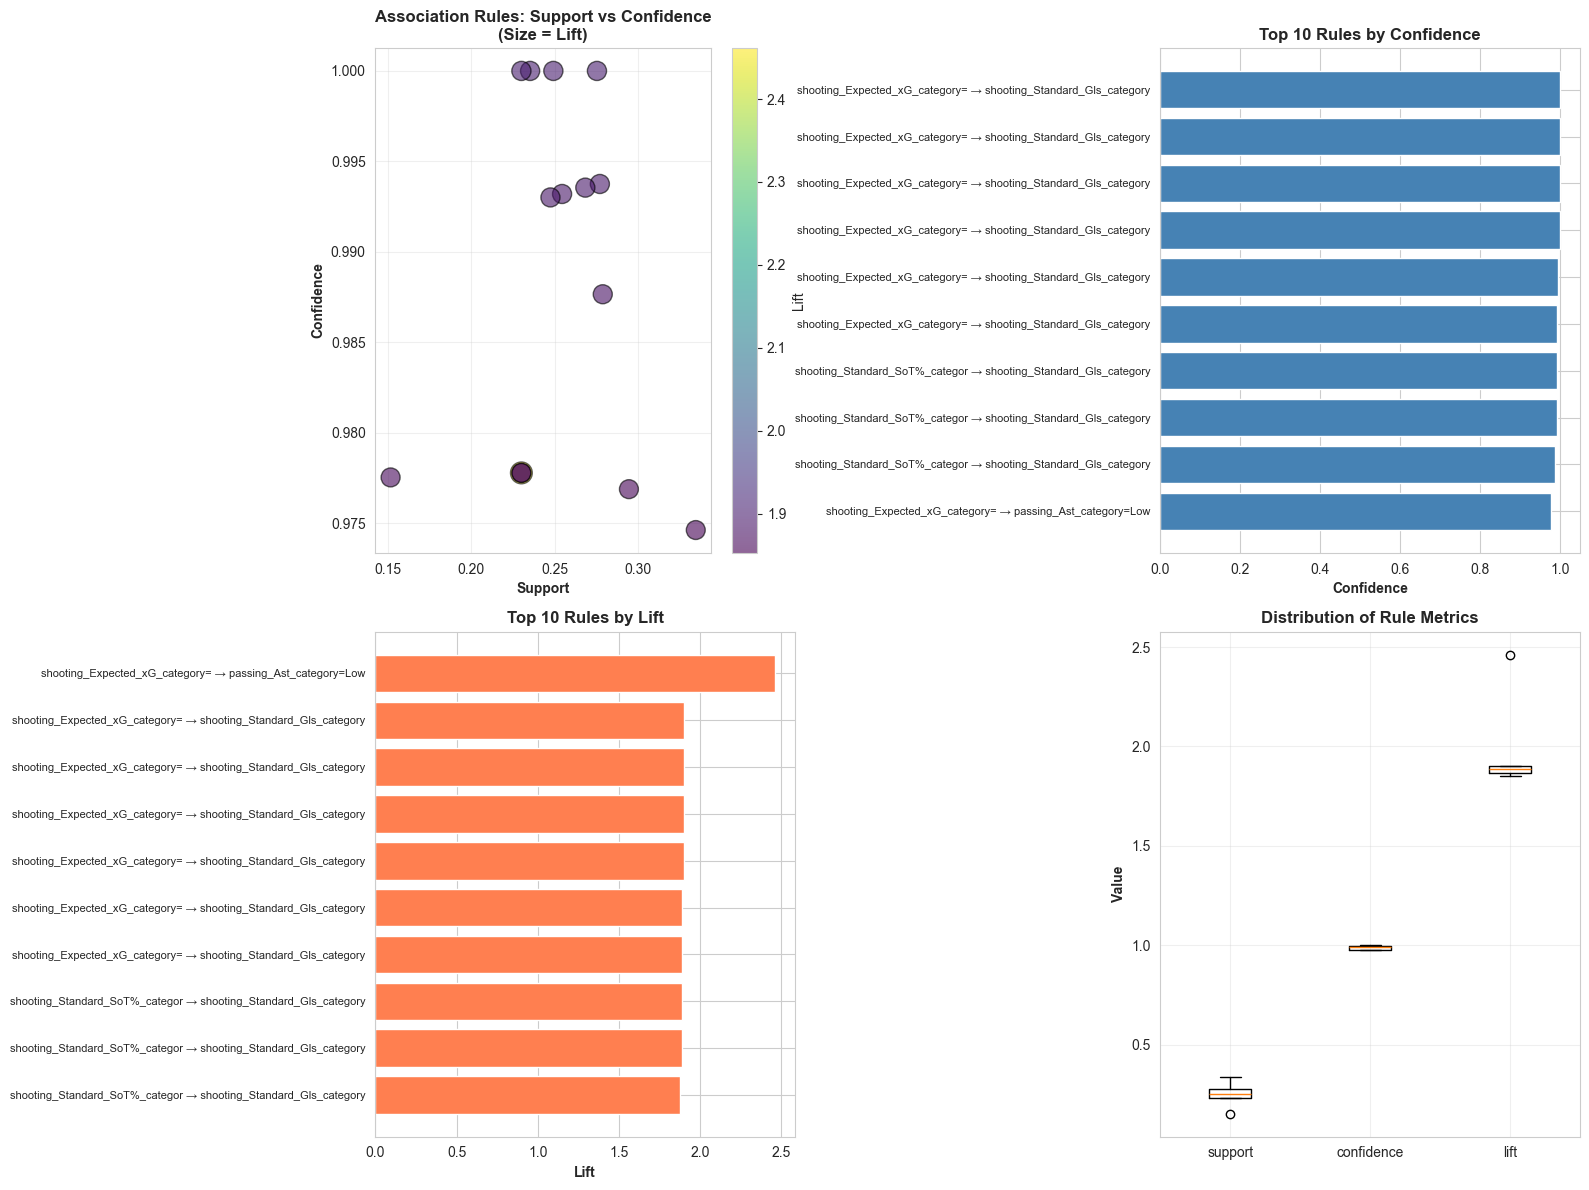


✅ Đã lưu kết quả vào results/association_rules/


In [4]:
# Visualize association rules
if rules_players is not None and len(rules_players) > 0:
    # Lọc top 15 rules có confidence và lift cao
    top_rules = rules_players.head(15).copy()
    
    # Tạo visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Scatter plot: Support vs Confidence
    ax1 = axes[0, 0]
    scatter = ax1.scatter(top_rules['support'], top_rules['confidence'], 
                          s=top_rules['lift']*100, c=top_rules['lift'], 
                          cmap='viridis', alpha=0.6, edgecolors='black')
    ax1.set_xlabel('Support', fontweight='bold')
    ax1.set_ylabel('Confidence', fontweight='bold')
    ax1.set_title('Association Rules: Support vs Confidence\n(Size = Lift)', fontweight='bold')
    plt.colorbar(scatter, ax=ax1, label='Lift')
    ax1.grid(True, alpha=0.3)
    
    # 2. Bar chart: Top 10 rules by confidence
    ax2 = axes[0, 1]
    top_conf = top_rules.head(10)
    rule_labels = [f"{str(list(rule['antecedents'])[0])[:30]} → {str(list(rule['consequents'])[0])[:30]}" 
                    for _, rule in top_conf.iterrows()]
    ax2.barh(range(len(top_conf)), top_conf['confidence'], color='steelblue')
    ax2.set_yticks(range(len(top_conf)))
    ax2.set_yticklabels(rule_labels, fontsize=8)
    ax2.set_xlabel('Confidence', fontweight='bold')
    ax2.set_title('Top 10 Rules by Confidence', fontweight='bold')
    ax2.invert_yaxis()
    
    # 3. Bar chart: Top 10 rules by lift
    ax3 = axes[1, 0]
    top_lift = top_rules.nlargest(10, 'lift')
    rule_labels_lift = [f"{str(list(rule['antecedents'])[0])[:30]} → {str(list(rule['consequents'])[0])[:30]}" 
                        for _, rule in top_lift.iterrows()]
    ax3.barh(range(len(top_lift)), top_lift['lift'], color='coral')
    ax3.set_yticks(range(len(top_lift)))
    ax3.set_yticklabels(rule_labels_lift, fontsize=8)
    ax3.set_xlabel('Lift', fontweight='bold')
    ax3.set_title('Top 10 Rules by Lift', fontweight='bold')
    ax3.invert_yaxis()
    
    # 4. Distribution of metrics
    ax4 = axes[1, 1]
    metrics = ['support', 'confidence', 'lift']
    data_to_plot = [top_rules[m] for m in metrics]
    ax4.boxplot(data_to_plot, labels=metrics)
    ax4.set_ylabel('Value', fontweight='bold')
    ax4.set_title('Distribution of Rule Metrics', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/association_rules/player_rules_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Lưu kết quả
    frequent_itemsets_players.to_csv('../results/association_rules/player_frequent_itemsets.csv', index=False)
    rules_players.to_csv('../results/association_rules/player_rules.csv', index=False)
    print("\n✅ Đã lưu kết quả vào results/association_rules/")


## 3. Phân tích mẫu đội bóng (nếu có dữ liệu)


PHÂN TÍCH MẪU ĐỘI BÓNG
📊 Đang phân tích đội bóng với 5 features...

✅ Tìm thấy 19 frequent itemsets
✅ Tạo được 12 association rules

TOP ASSOCIATION RULES CHO ĐỘI BÓNG:
                             antecedents                            consequents  support  confidence      lift
4   (Pts_category=Low, GA_category=High)                    (xGA_category=High)      0.3    1.000000  2.857143
5  (Pts_category=Low, xGA_category=High)                     (GA_category=High)      0.3    1.000000  2.857143
6  (xGA_category=High, GA_category=High)                     (Pts_category=Low)      0.3    1.000000  2.857143
7                     (Pts_category=Low)  (xGA_category=High, GA_category=High)      0.3    0.857143  2.857143
8                     (GA_category=High)  (Pts_category=Low, xGA_category=High)      0.3    0.857143  2.857143
9                    (xGA_category=High)   (Pts_category=Low, GA_category=High)      0.3    0.857143  2.857143
0                     (Pts_category=Low)              

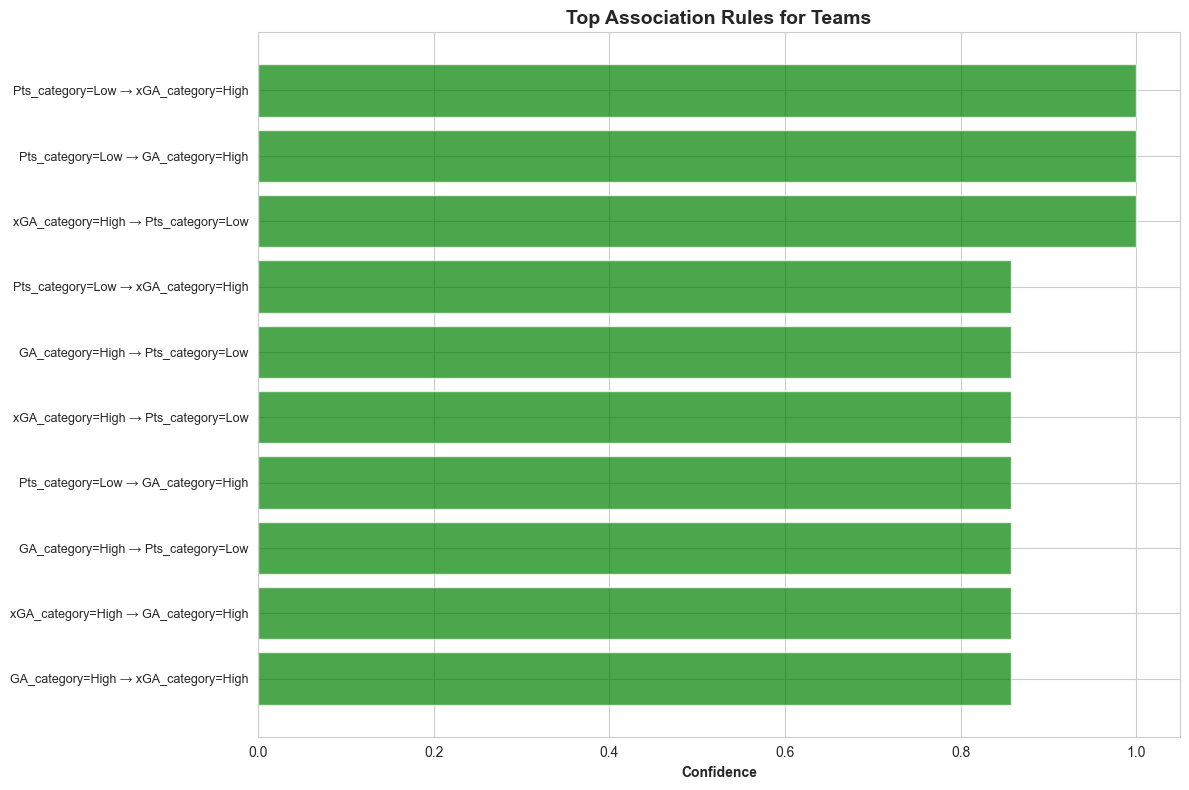


✅ Đã lưu kết quả đội bóng


In [5]:
# Phân tích mẫu đội bóng
if teams_df is not None:
    print("="*70)
    print("PHÂN TÍCH MẪU ĐỘI BÓNG")
    print("="*70)
    
    frequent_itemsets_teams, rules_teams, teams_discrete = analyze_team_patterns(
        teams_df, min_support=0.3, min_confidence=0.7
    )
    
    if frequent_itemsets_teams is not None and len(frequent_itemsets_teams) > 0:
        print(f"\n✅ Tìm thấy {len(frequent_itemsets_teams)} frequent itemsets")
        print(f"✅ Tạo được {len(rules_teams)} association rules")
        
        # Hiển thị top rules
        if len(rules_teams) > 0:
            print("\n" + "="*70)
            print("TOP ASSOCIATION RULES CHO ĐỘI BÓNG:")
            print("="*70)
            print(rules_teams.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())
            
            # Visualize
            if len(rules_teams) > 0:
                top_rules_teams = rules_teams.head(10)
                fig, ax = plt.subplots(figsize=(12, 8))
                rule_labels = [f"{str(list(rule['antecedents'])[0])[:40]} → {str(list(rule['consequents'])[0])[:40]}" 
                              for _, rule in top_rules_teams.iterrows()]
                ax.barh(range(len(top_rules_teams)), top_rules_teams['confidence'], color='green', alpha=0.7)
                ax.set_yticks(range(len(top_rules_teams)))
                ax.set_yticklabels(rule_labels, fontsize=9)
                ax.set_xlabel('Confidence', fontweight='bold')
                ax.set_title('Top Association Rules for Teams', fontweight='bold', fontsize=14)
                ax.invert_yaxis()
                plt.tight_layout()
                plt.savefig('../results/association_rules/team_rules_visualization.png', dpi=300, bbox_inches='tight')
                plt.show()
                
                # Lưu kết quả
                frequent_itemsets_teams.to_csv('../results/association_rules/team_frequent_itemsets.csv', index=False)
                rules_teams.to_csv('../results/association_rules/team_rules.csv', index=False)
                print("\n✅ Đã lưu kết quả đội bóng")
    else:
        print("⚠️ Không tìm thấy patterns cho đội bóng")
else:
    print("⚠️ Không có dữ liệu đội bóng để phân tích")


## 4. Tổng kết

Các association rules tìm được cho thấy các mẫu kết hợp giữa các chỉ số cầu thủ/đội bóng. 
Các rules có confidence và lift cao là những patterns đáng tin cậy và có ý nghĩa.
